1. Pre-processing

In [65]:
from project.data_extraction.dummy_data_extractor import extract_dummy_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline

master_table = extract_dummy_data(r"C:\Users\ccarandang\OneDrive - Enova Facilities Management\Documents\GitHub\HubgradeDataCleaning\HubgradeDataCleaning\project\dummy_data")
master_table = master_table.at[0,"his"]
df = master_table.dropna()

In [48]:
X_full = df.iloc[:,2:].to_numpy()
X_full

array([[ 0.        ],
       [ 4.10196114],
       [24.86417007],
       ...,
       [35.32480621],
       [33.50623703],
       [33.50623703]])

In [49]:
y = df.iloc[:,2:]
y

,DMC Building 1 Data Quality Tests New-Point
1215,0.000000
1216,4.101961
1217,24.864170
1218,28.627068
1219,32.381767
...,...
4391,31.959213
4392,33.179718
4393,35.324806
4394,33.506237


In [50]:
N_SPLITS = 5

X_full = df.iloc[:,2:].to_numpy()
y = df.iloc[:,1:-1].to_numpy()              # First column after the timestamp will be y
y_full = np.ravel(y)                        #Flatten
n_samples, n_features = X_full.shape

In [51]:
# Estimate the score on the entire dataset, with no missing values
br_estimator = BayesianRidge()
score_full_data = pd.DataFrame(
    cross_val_score(
        br_estimator, X_full, y_full, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    ),
    columns=["Full Data"],
)

In [72]:
#Table with NaN 
df_nan = master_table.loc[~master_table.index.isin(master_table.dropna().index)]
df_nan

,ts,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point
0,2023-02-24 18:45:00+04:00,24.420517,NaN
1,2023-02-24 18:50:00+04:00,24.420517,NaN
2,2023-02-24 18:55:00+04:00,24.420517,NaN
3,2023-02-24 19:00:00+04:00,24.345844,NaN
4,2023-02-24 19:05:00+04:00,24.271170,NaN
...,...,...,...
1210,2023-02-28 23:35:00+04:00,23.208195,NaN
1211,2023-02-28 23:40:00+04:00,23.208195,NaN
1212,2023-02-28 23:45:00+04:00,23.208195,NaN
1213,2023-02-28 23:50:00+04:00,23.208195,NaN


In [73]:
X_missing = master_table.iloc[:,2:].to_numpy()
y_nan = master_table.iloc[:,1:-1].to_numpy()             
y_missing = np.ravel(y_nan)                        


In [74]:
# Estimate the score after imputation (mean and median strategies)
score_simple_imputer = pd.DataFrame()
for strategy in ("mean", "median"):
    estimator = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy=strategy), br_estimator
    )
    score_simple_imputer[strategy] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    )

In [75]:
# Estimate the score after iterative imputation of the missing values
# with different estimators
estimators = [
    BayesianRidge(),
    RandomForestRegressor(
        # We tuned the hyperparameters of the RandomForestRegressor to get a good
        # enough predictive performance for a restricted execution time.
        n_estimators=4,
        max_depth=10,
        bootstrap=True,
        max_samples=0.5,
        n_jobs=2,
        random_state=0,
    ),
    make_pipeline(
        Nystroem(kernel="polynomial", degree=2, random_state=0), Ridge(alpha=1e3)
    ),
    KNeighborsRegressor(n_neighbors=15),
]
score_iterative_imputer = pd.DataFrame()

In [77]:
# iterative imputer is sensible to the tolerance and
# dependent on the estimator used internally.
# we tuned the tolerance to keep this example run with limited computational
# resources while not changing the results too much compared to keeping the
# stricter default value for the tolerance parameter.
tolerances = (1e-3, 1e-1, 1e-1, 1e-2)
for impute_estimator, tol in zip(estimators, tolerances):
    estimator = make_pipeline(
        IterativeImputer(
            random_state=0, estimator=impute_estimator, max_iter=25, tol=tol
        ),
        br_estimator,
    )
    score_iterative_imputer[impute_estimator.__class__.__name__] = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_root_mean_squared_error", cv=N_SPLITS
    )

scores = pd.concat(
    [score_full_data, score_simple_imputer, score_iterative_imputer],
    keys=["Original", "SimpleImputer", "IterativeImputer"],
    axis=1,
)
scores

Original SimpleImputer           IterativeImputer                        \
  Full Data          mean    median    BayesianRidge RandomForestRegressor   
0 -0.481037     -0.774248 -0.785173        -0.774248             -0.774248   
1 -0.836395     -0.542699 -0.549422        -0.542699             -0.542699   
2 -0.656494     -0.929806 -0.941964        -0.929806             -0.929806   
3 -0.595816     -0.580864 -0.575631        -0.580864             -0.580864   
4 -1.032087     -0.795379 -0.800561        -0.795379             -0.795379   

                                 
   Pipeline KNeighborsRegressor  
0 -0.774248           -0.774248  
1 -0.542699           -0.542699  
2 -0.929806           -0.929806  
3 -0.580864           -0.580864  
4 -0.795379           -0.795379

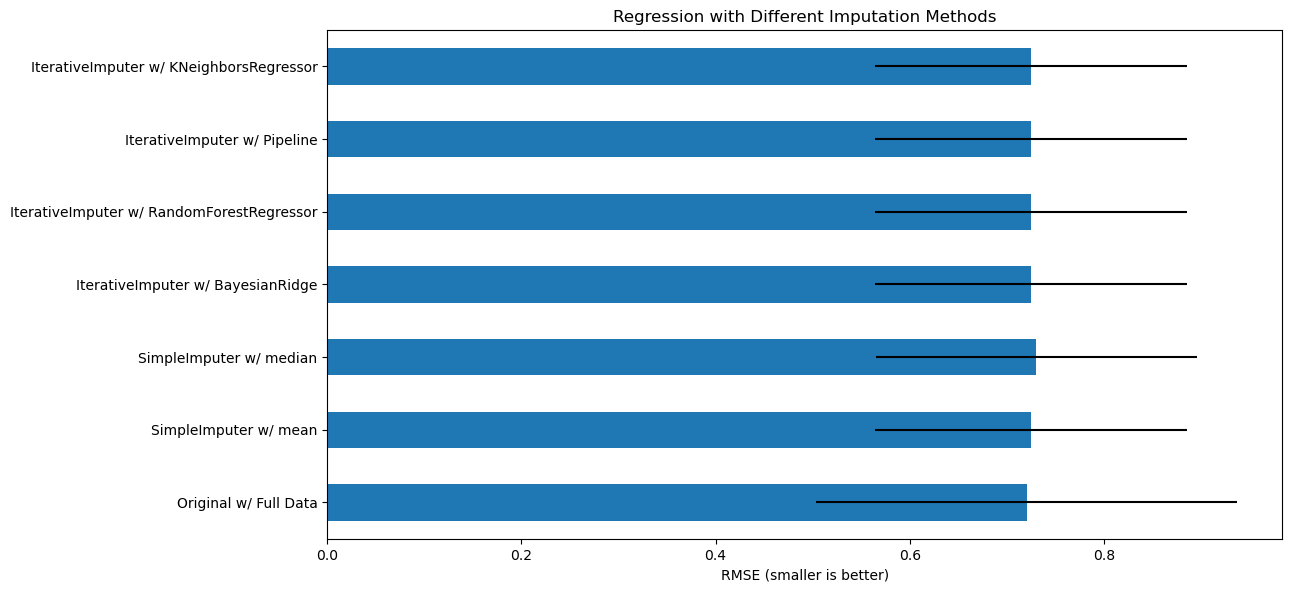

In [78]:
# plot results
fig, ax = plt.subplots(figsize=(13, 6))
means = -scores.mean()
errors = scores.std()
means.plot.barh(xerr=errors, ax=ax)
ax.set_title("Regression with Different Imputation Methods")
ax.set_xlabel("RMSE (smaller is better)")
ax.set_yticks(np.arange(means.shape[0]))
ax.set_yticklabels([" w/ ".join(label) for label in means.index.tolist()])
plt.tight_layout(pad=1)
plt.show()

2. Nearest Neighbors Regression

In [86]:
from sklearn.model_selection import train_test_split
 
# Load the dataset
X = df.iloc[:,2:]
y = df.iloc[:,2:]
 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 
# Apply KNN regression
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
predictions = knn_regressor.predict(X_test)
 
# Evaluate the model
print('Score:', knn_regressor.score(X_test, y_test))

Score: 0.9999405970436933


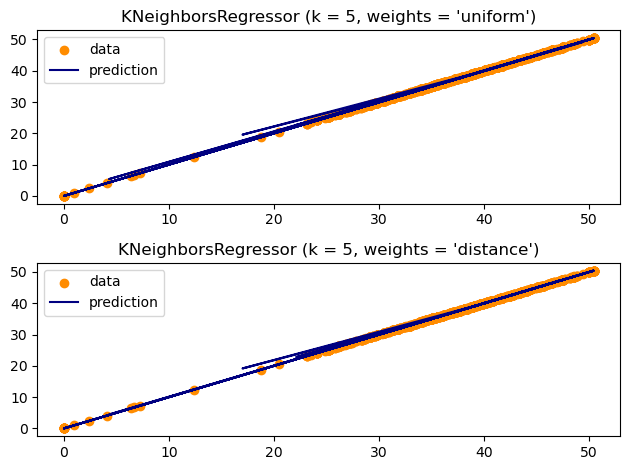

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import neighbors

X = df.iloc[:,2:]
y = df.iloc[:,2:]
 
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_neighbors = 5

for i, weights in enumerate(["uniform", "distance"]):
    knn = neighbors.KNeighborsRegressor(n_neighbors, weights=weights)
    y_ = knn.fit(X_train, y_train).predict(X_test)

    plt.subplot(2, 1, i + 1)
    plt.scatter(X_train, y_train, color="darkorange", label="data")
    plt.plot(X_test, y_, color="navy", label="prediction")
    plt.axis("tight")
    plt.legend()
    plt.title("KNeighborsRegressor (k = %i, weights = '%s')" % (n_neighbors, weights))

plt.tight_layout()
plt.show()